In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from data_clean import dz_clean, daz_clean, dbz_clean
from scipy.stats import pearsonr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

In [16]:
clean_data_functions_dict = {0 :dz_clean(),
                             1 :daz_clean(),
                             2 :dbz_clean()}
clean_data_names_dict = {0 :"DZ White Dwarfs",
                         1 :"DAZ White Dwarfs",
                         2 :"DBZ White Dwarfs"}
significant_metals_for_each_type = {0 :["logcahe","logmghe"],                   # These are the only metals which show significant correlation with mass as per the results obtained above. So we will analyze them further
                                    1 :"lognih",
                                    2 :"logcahe"}


MULTI-VARIABLE ANALYSIS

Now instead of analysing the metal abundance relationship with all the factors one by one, we can analyse the effects of all the factors at once using multivariable analysis. Instead of finding correlation and p- value, we can find R² value by fitting a linear model to the data. This value tells us the extent to which the independent parameters affect our dependent parameter, i.e, Metal abundance.

We want to plot all of the below values on the X-axis while the metal abundance will be on Y-axis :           
                                                                
Our independent variables are  :                                  
                                                           
1) teff = Effective temperature, in kelvin                    
2) logg =Log of surface gravity, in cm/s2                     
3) mass=  Mass in solar mass                                  
4) age = Cooling age of the star in Gyr     

Our dependent variable is:
                                                           
1) Only the significant metal ratios that we got                   


First we try Linear Regression :

In [17]:
parameter_list = ["teff","logg","mass","age"]                                                                           # These are the parameters that affect the metal abundance on white dwarf surface. Their values are already included in our data

for i in range(len(clean_data_functions_dict)):

    def x_parameters_multivariate():
        drop_NaN_values = clean_data_functions_dict.get(i).loc[:, parameter_list[:]].dropna(axis=0)
        drop_NaN_values[parameter_list[:]] = drop_NaN_values[parameter_list[:]].apply(pd.to_numeric, errors='coerce')      # ".apply" does similar thing as the previously defined functions, but shorter
        drop_NaN_values_again = drop_NaN_values.dropna(axis=0)   
        return drop_NaN_values_again                                                                                       # This function contains the values of the 4 parameters defined above, for each of the 3 datasets: DZ, DAZ, DBZ respectively
    
    def y_parameters_multivariate():  
        if isinstance(significant_metals_for_each_type.get(i),list):
            for j in range(len(significant_metals_for_each_type.get(i))):                
                drop_NaN_values =clean_data_functions_dict.get(i).loc[:,[significant_metals_for_each_type.get(i)[j]]].dropna(axis=0)
                drop_NaN_values[significant_metals_for_each_type.get(i)[j]]= drop_NaN_values[significant_metals_for_each_type.get(i)[j]].apply(pd.to_numeric, errors='coerce') 
                drop_NaN_values_again = drop_NaN_values.dropna(axis=0)
                return drop_NaN_values_again                                                                                
            
        elif isinstance(significant_metals_for_each_type.get(i),str):
            drop_NaN_values =clean_data_functions_dict.get(i).loc[:,[significant_metals_for_each_type.get(i)]].dropna(axis=0)
            drop_NaN_values[significant_metals_for_each_type.get(i)]= drop_NaN_values[significant_metals_for_each_type.get(i)].apply(pd.to_numeric, errors='coerce') 
            drop_NaN_values_again = drop_NaN_values.dropna(axis=0)
            return drop_NaN_values_again                                                                                    # This function contains the log ratios of significant metals, for each of the 3 datasets: DZ, DAZ, DBZ respectively
       

In [18]:
x = x_parameters_multivariate()
y = y_parameters_multivariate()               # We define x and y. But they can still have different shapes. We want them to have equal shape

In [19]:
combined_data = pd.concat([x, y], axis=1).dropna()
x = combined_data.iloc[:, :-1]            
y = combined_data.iloc[:, -1]                            # If any of the value in "x" OR "y" are missing for a particular row, that entire row will be removed.


In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

In [21]:
lr.fit(x_train,y_train)            # fit the model

LinearRegression()

In [22]:
coeff = lr.coef_
coeff                              # This gives us how well are the parameters ["teff","logg","mass","age"] related to metal abundance, respectively. 

array([ 5.19288193e-05, -1.38727640e+00,  1.51629846e+00, -6.07063246e-01])

MACHINE LEARNING MODEL

In [23]:
y_train_predict = lr.predict(x_train)   # Predicts the training data based on model


In [24]:
df_x_1 = pd.DataFrame(x_train)                                  # convert x_train and y_train from np array into dataframes to make them of equal shape by dropping NaN values
df_y_1 = pd.DataFrame(y_train)

combined_data_train = pd.concat([df_x_1, df_y_1], axis=1)       # Combine them into one DataFrame

combined_data_train = combined_data_train.dropna()              # Drop rows with NaN values

x_train = combined_data_train.iloc[:, :-1].to_numpy()           # Separate them back into x_train and y_train arrays
y_train = combined_data_train.iloc[:, -1].to_numpy()            # they will have same shape now

In [25]:
df_x_2 = pd.DataFrame(x_train)                                   # we do same thing with x_train and y_train_predict
df_y_2 = pd.DataFrame(y_train_predict)

combined_data_predict = pd.concat([df_x_2, df_y_2], axis=1)

combined_data_predict = combined_data_predict.dropna()

x_train_predict = combined_data_predict.iloc[:, :-1].to_numpy()  
y_train_predict = combined_data_predict.iloc[:, -1].to_numpy()    

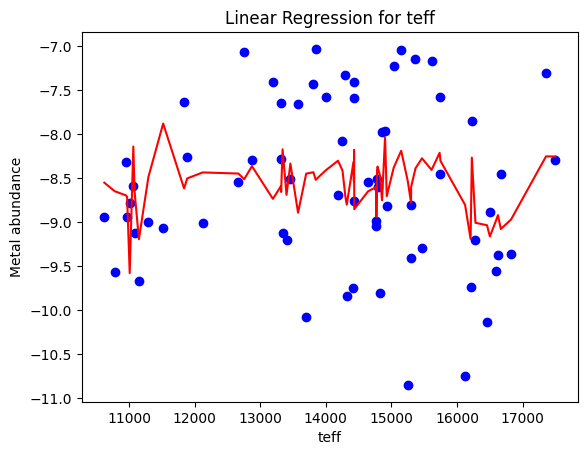

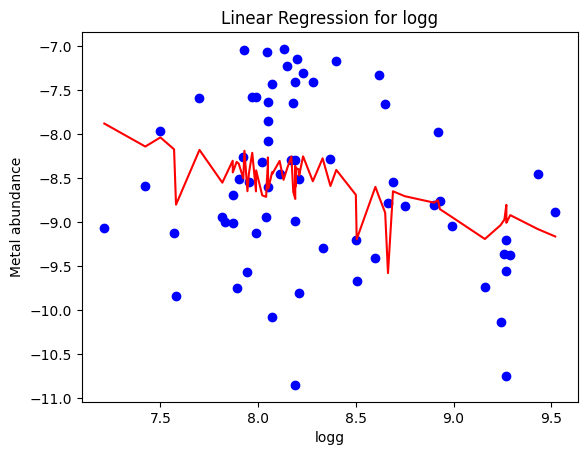

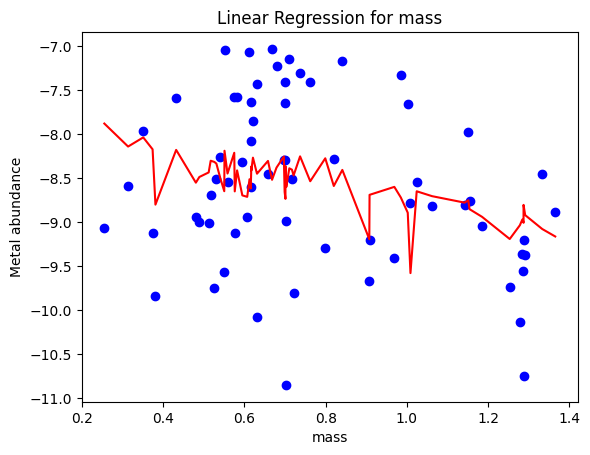

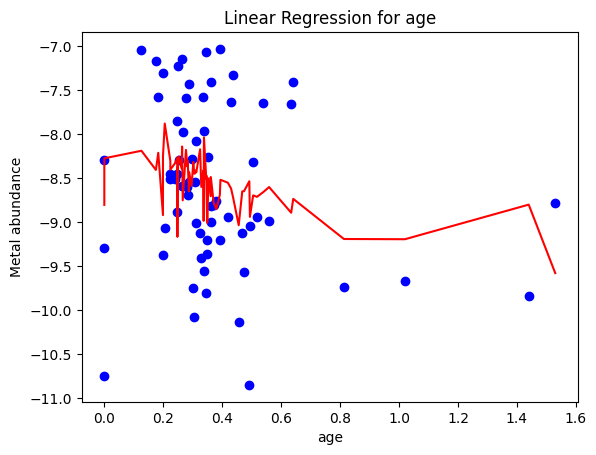

In [26]:
for index,parameter in enumerate(parameter_list):                              # For plotting 

    sort_axis= np.argsort(x_train_predict[:, index])                           # Sorting both x_train_predict and y_train_predict in increasing order otherwise we get a jumbled line
    sorted_x = x_train_predict[sort_axis]
    sorted_y_pred = y_train_predict[sort_axis] 
     
    plt.scatter(x_train[:, index],y_train, color='blue', label="Actual Data Points")  
    plt.plot(sorted_x[:, index],sorted_y_pred, color='red', label="Linear Fit")
    plt.title(f"Linear Regression for {parameter}")
    plt.xlabel(f"{parameter}")
    plt.ylabel("Metal abundance")
    plt.show()

In [27]:
r2_train_linear =r2_score(y_train,y_train_predict)                    
r2_train_linear =r2_score(y_train,y_train_predict)                       
print(f"R² Score for linear model: {r2_train_linear}")

R² Score for linear model: 0.11390159958731805


THE OVERVIEW OF LINEAR MODEL PERFORMANCE :

R² Score is coefficient of determination. It tells us how well the independent variables in a regression model explain the variability of the dependent variable. Here we get to know how much the Metal abundance on the white dwarf surface depends on parameters like "teff","logg","mass" and "age".

An R² score of 0.1139 means that the model is only explaining about 11.4% of the variance in the metal abundances based on the parameters.This is a relatively low R² score, which suggests that current linear model isn't capturing the relationships between the two correctly. The reasons might be -:

1) The relationship amongst the metal abundance and the above parameters might not be linear. Linear relation occurs when one of the  quantity increases and the other quantity increases by the same proportion. But the parameters most likely dont follow linear relation. There is no specific formula to predict that if a white dwarf temperature is increased by 500 degrees how much will be the increase in metals visible on surface. This is most likely the reason that the R² score is less in this case.

2) The data that I selected was taken from Montreal White Dwarf Database containing information of about 1300 objects for DZ type, 423 DAZ type objects and 100 DBZ type objects. The data might have had outliers which affected the model, or the data might have been too small to train the model. There is a possibility that if the data size is increased then the linear model will give better results.

3) There might be additional parameters affecting the metal abundance which I didnt consider for the model, like ongoing metal accretion. The available data for such parameters is limited. So it is possible that including such data will further reduce the efficiency of model.


Polynomial fitting

R² Score for polynomial model: 0.5440127287118128


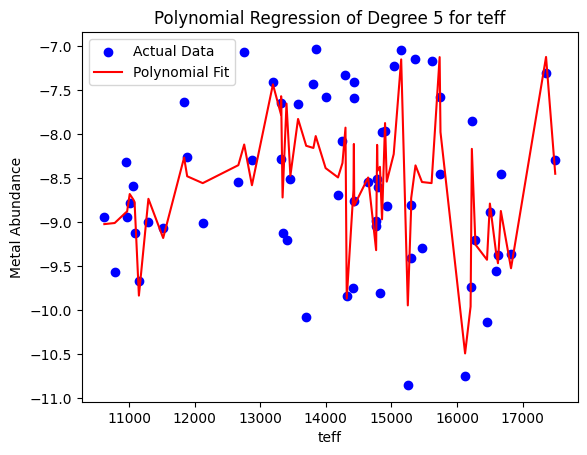

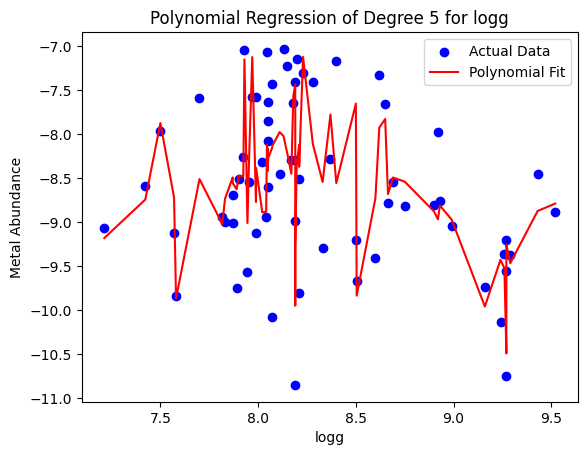

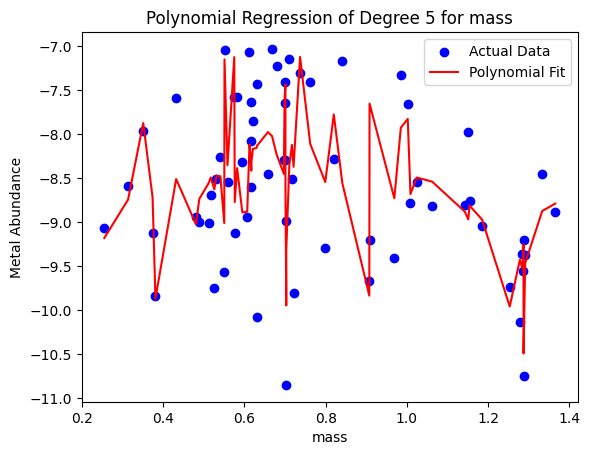

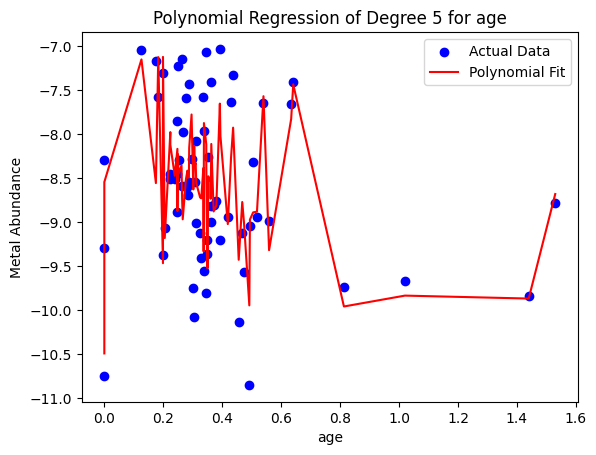

In [28]:
poly = PolynomialFeatures(degree=5)
x_poly = poly.fit_transform(x_train)                                                 # Transform linear parameters defined above into polynomial form
model = lr.fit(x_poly, y_train)

y_train_predict = model.predict(x_poly)

r2_train_poly = r2_score(y_train, y_train_predict)
print(f"R² Score for polynomial model: {r2_train_poly}")

if isinstance(x_train, pd.DataFrame):                                                # If x_train is a DataFrame, this converts it to np array
    x_train = x_train.values

for index,parameter in enumerate(parameter_list):                                     # Plotting each parameter amongst "teff","logg","mass","age" with the Metal Abundance
    sort_axis = np.argsort(x_train[:, index])  
    sorted_x = x_train[sort_axis]                                                     # Sorting the x_train in increasing order otherwise we get a jumbled line
    sorted_y_pred = y_train_predict[sort_axis]                                      # Sorting predictions similar to above

    plt.scatter(x_train[:, index], y_train, color='blue', label="Actual Data")        # Plot data points
    plt.plot(sorted_x[:, index], sorted_y_pred, color='red', label="Polynomial Fit")  # Plot fitted regression line
    plt.title(f"Polynomial Regression of Degree 5 for {parameter}")
    plt.xlabel(f"{parameter}")
    plt.ylabel("Metal Abundance")
    plt.legend()
    plt.show()


This gives us abetter approximation of the relationship between the parameters and surface metal accretion, i.e, with an R² Score of 54%. 